# Assignment 3 Exercise 2

## Description
Use `negative selection` to detect the anomalous sequences in the system calls dataset: `snd-cert`

Perform an AUC analysis to evaluate the quality of your classification. Choose the parameters n and r for the negative selection algorithm yourself. You can use the parameters from the language example as a starting point.

In [1]:
import math
import pickle
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
# global variables
CERT = "negative-selection/syscalls/snd-cert/"
UNM = "negative-selection/syscalls/snd-unm/"
OUT = "syscalls-classification/"
OVERLAP = False
CHUNK_LENGTH = 7
TEST_N = 3

Max value of `CHUNK_LENGTH` = 7 because that is the smallest sequence length in the given training dataset. 

### Step 1: Dataset Pre-processing

Define helper functions for pre-processing datasets

In [3]:
def read_data(path):
    '''function to read files'''
    with open(path, "r") as data:
        lines = data.read().splitlines()
    return lines

def fixed_length_chunks(string, length, overlap=False):
    '''function to create a fixed length chunks of a dataset'''
    step = 1 if overlap else length
    max_step = max(len(string) - length + 1, 1) if overlap else len(string)
    chunks = list( (string[i:length+i] for i in range(0, max_step, step)) )
    if not overlap:
        last_chunk_length_diff = length - len(chunks[-1])
        # force last chunk to be fixed length by adding a part from the penultimate chunk
        if len(chunks) > 1 and last_chunk_length_diff != 0:
            chunks[-1] = (chunks[-2] + chunks[-1])[-length:]
    return chunks

Functions for training data

In [4]:
def remove_duplicates(chunks):
    """Removes duplicate chunks (use only for training data)."""
    duplicates = set()
    output = []
    for chunk in chunks:
        if chunk not in duplicates:
            duplicates.add(chunk)
            output.append(chunk)
    return output

def process_train_sequences(sequences, chunk_length, overlap):
    '''function to create fixed length chunks and remove duplicates'''
    chunked_sequences = [fixed_length_chunks(seq, chunk_length, overlap) for seq in sequences]
    chunks = [chunk for chunks in chunked_sequences for chunk in chunks]
    return remove_duplicates(chunks)    

def write_train_data(chunks, out_dir):
    '''function to write chunks in a file'''
    with open(out_dir, "w") as train:
        train.write('\n'.join(chunks))

Functions for test data

In [5]:
def read_test_and_labels(path_no_ext):
    '''function to fetch test dataset files'''
    test = read_data(path_no_ext + ".test")
    labels = read_data(path_no_ext + ".labels")
    return test, labels

def process_test_sequences(labeled_sequences, chunk_length, overlap):
    '''function to create fixed length chunks and remove duplicates'''
    chunked_sequences = [list(map(lambda x: (x, label), fixed_length_chunks(seq, chunk_length, overlap)))
                         for seq, label in labeled_sequences]
    chunks = [chunk for chunks in chunked_sequences for chunk in chunks]
    return chunks

def write_test_data(labeled_chunks, out_dir_no_ext):
    '''function to write chunks in a file'''
    chunks = [chunk for chunk, _ in labeled_chunks]
    lbls = [label for _, label in labeled_chunks]
    with open(out_dir_no_ext + ".test", "w") as test, open(out_dir_no_ext + ".labels", "w") as labels:
        test.write('\n'.join(chunks))
        labels.write('\n'.join(lbls))

Functions for preprocessing datasets

In [6]:
def preprocess_train_data(chunk_length, overlap):
    # snd-cert
    train_unm = read_data(UNM + "snd-unm.train")
    chunks_unm = process_train_sequences(train_unm, chunk_length, overlap)
    write_train_data(chunks_unm, OUT + "snd-unm/snd-unm.{}.train".format(chunk_length))
    
def preprocess_test_data(chunk_length, overlap):
    for i in range(1, 4):
        # snd-unm
        test_unm, labels_unm = read_test_and_labels(UNM + f"snd-unm.{i}")
        labeled_chunks_unm = process_test_sequences(zip(test_unm, labels_unm), chunk_length, overlap)
        write_test_data(labeled_chunks_unm, OUT + f"snd-unm/snd-unm.{chunk_length}.{i}")

Pre-process training and test datasets

In [7]:
for chk_len in tqdm(range(1, CHUNK_LENGTH + 1)):
    preprocess_train_data(chk_len, overlap=OVERLAP)

In [8]:
for chk_len in tqdm(range(1, CHUNK_LENGTH + 1)):
    preprocess_test_data(chk_len, overlap=OVERLAP)

### Step 2: Classification Task
Functions to perform AUC analysis

In [9]:
def get_AUC(anomaly_labels, anomaly_scores):
    """Compute AUC from labels and predictions (scores)."""
    fpr, tpr, thresholds = metrics.roc_curve(anomaly_labels, anomaly_scores, pos_label=1)
    return metrics.auc(fpr, tpr)

def plot_ROC(fpr, tpr, title="", filename=None):
    """Plot ROC with its AUC."""
    auc = metrics.auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], '--')
    plt.plot(fpr, tpr, label=f"AUC={auc:.2f}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve ' + title)
    plt.legend()
    if filename:
        plt.savefig(f'figures/ex2/{filename}.png')
    plt.show()

In [13]:
# static variables
unm_data_path = OUT + "snd-unm/"
jar = f"-jar negative-selection/negsel2.jar"
alpha = f"-alphabet file://{UNM}snd-unm.alpha"

In [14]:
# create tuples of CHUNK_LENGTH and R_LENGTH for experiments
chunk_r_tuples = [(i,j) for i in range(1, CHUNK_LENGTH+1) for j in range(1, i+1)]
# dictionary for storing AUC values
auc_dict = dict()

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.1.train -n 1 -r 1 -c -l < syscalls-classification/snd-unm/snd-unm.1.1.test
AUC: 0.5


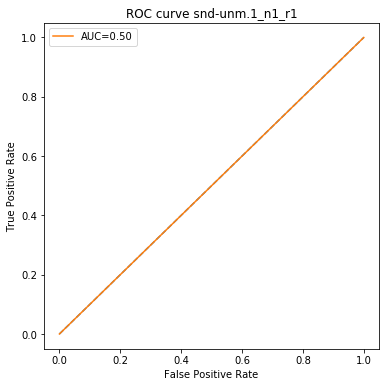

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.1.train -n 1 -r 1 -c -l < syscalls-classification/snd-unm/snd-unm.1.2.test
AUC: 0.5


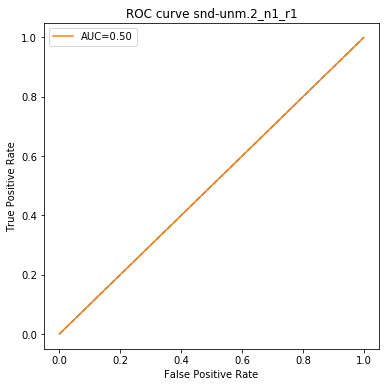

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.1.train -n 1 -r 1 -c -l < syscalls-classification/snd-unm/snd-unm.1.3.test
AUC: 0.5


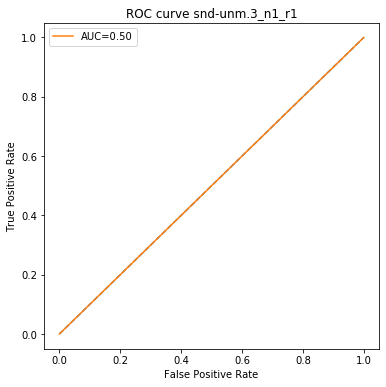

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.2.train -n 2 -r 1 -c -l < syscalls-classification/snd-unm/snd-unm.2.1.test
AUC: 0.5


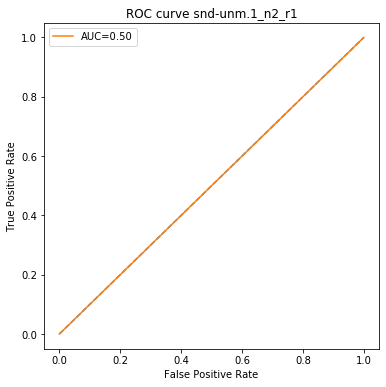

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.2.train -n 2 -r 1 -c -l < syscalls-classification/snd-unm/snd-unm.2.2.test
AUC: 0.4999955487104614


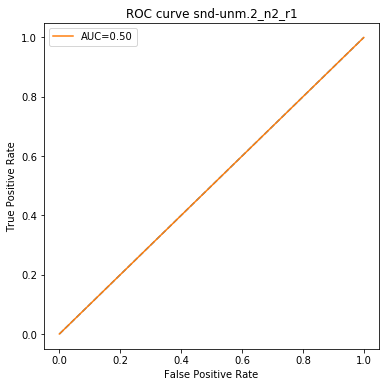

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.2.train -n 2 -r 1 -c -l < syscalls-classification/snd-unm/snd-unm.2.3.test
AUC: 0.49999773320246355


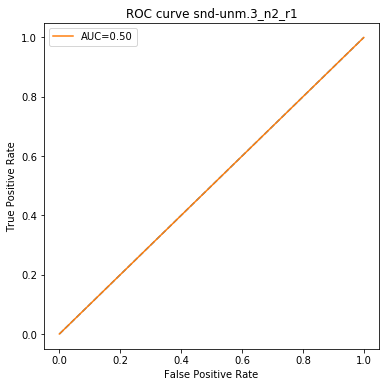

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.2.train -n 2 -r 2 -c -l < syscalls-classification/snd-unm/snd-unm.2.1.test
AUC: 0.5211812627291242


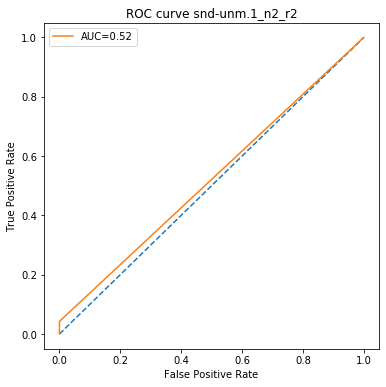

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.2.train -n 2 -r 2 -c -l < syscalls-classification/snd-unm/snd-unm.2.2.test
AUC: 0.520901423844624


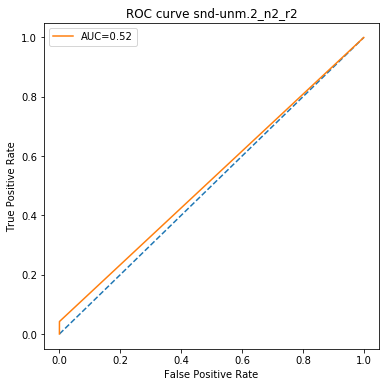

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.2.train -n 2 -r 2 -c -l < syscalls-classification/snd-unm/snd-unm.2.3.test
AUC: 0.5224597521637475


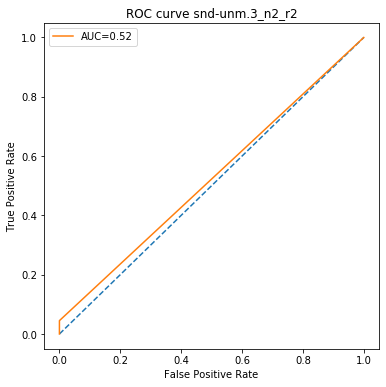

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.3.train -n 3 -r 1 -c -l < syscalls-classification/snd-unm/snd-unm.3.1.test
AUC: 0.5039015606242497


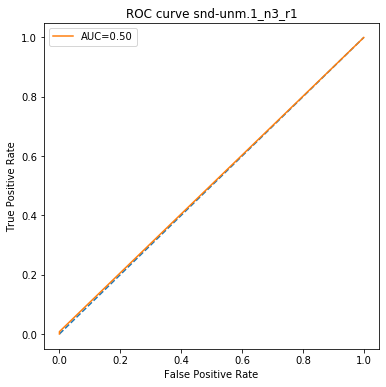

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.3.train -n 3 -r 1 -c -l < syscalls-classification/snd-unm/snd-unm.3.2.test
AUC: 0.5038319050927994


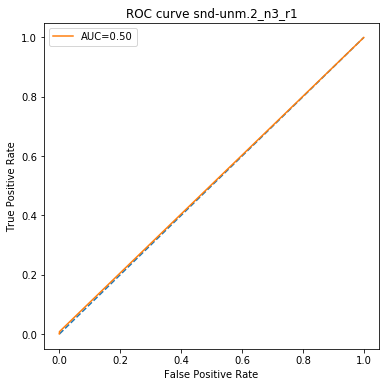

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.3.train -n 3 -r 1 -c -l < syscalls-classification/snd-unm/snd-unm.3.3.test
AUC: 0.5066185786162523


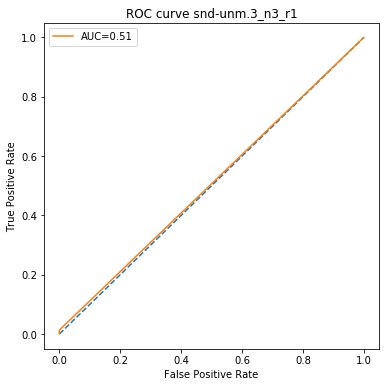

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.3.train -n 3 -r 2 -c -l < syscalls-classification/snd-unm/snd-unm.3.1.test
AUC: 0.5437810595106493


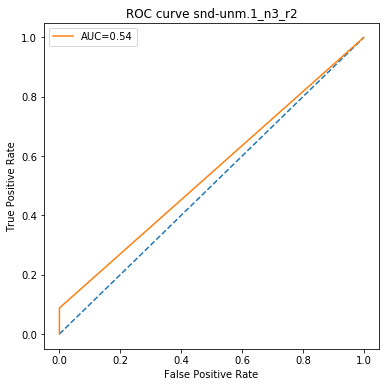

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.3.train -n 3 -r 2 -c -l < syscalls-classification/snd-unm/snd-unm.3.2.test
AUC: 0.5479061302837811


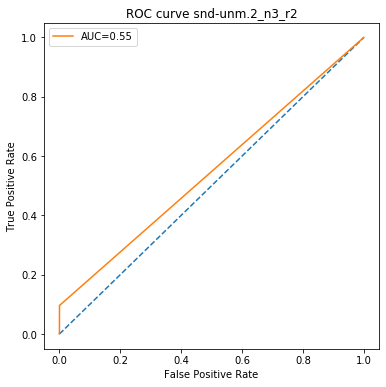

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.3.train -n 3 -r 2 -c -l < syscalls-classification/snd-unm/snd-unm.3.3.test
AUC: 0.5619893499271901


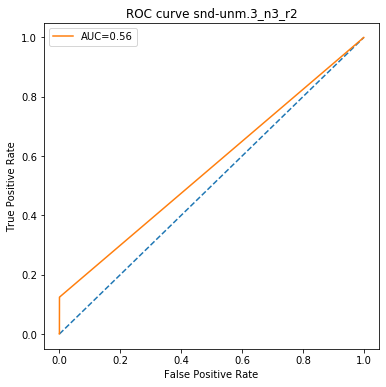

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.3.train -n 3 -r 3 -c -l < syscalls-classification/snd-unm/snd-unm.3.1.test
AUC: 0.5578865258085646


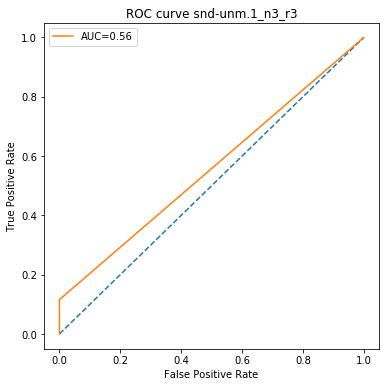

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.3.train -n 3 -r 3 -c -l < syscalls-classification/snd-unm/snd-unm.3.2.test
AUC: 0.5606348562431734


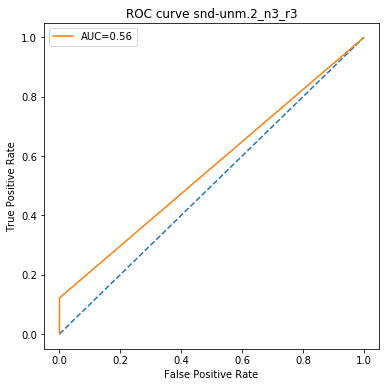

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.3.train -n 3 -r 3 -c -l < syscalls-classification/snd-unm/snd-unm.3.3.test
AUC: 0.5761336832747287


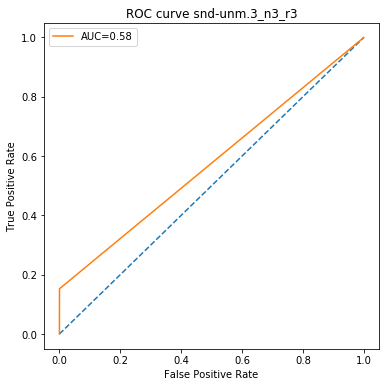

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.4.train -n 4 -r 1 -c -l < syscalls-classification/snd-unm/snd-unm.4.1.test
AUC: 0.5


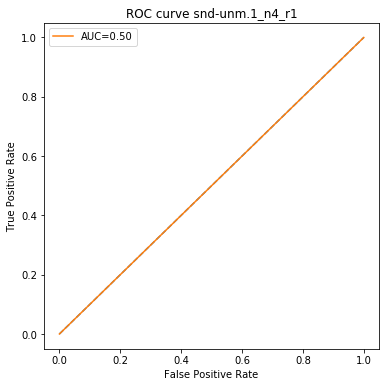

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.4.train -n 4 -r 1 -c -l < syscalls-classification/snd-unm/snd-unm.4.2.test
AUC: 0.500393999892141


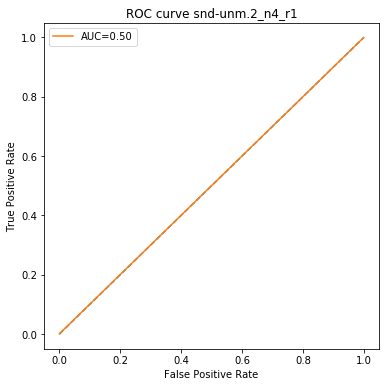

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.4.train -n 4 -r 1 -c -l < syscalls-classification/snd-unm/snd-unm.4.3.test
AUC: 0.4999954672782819


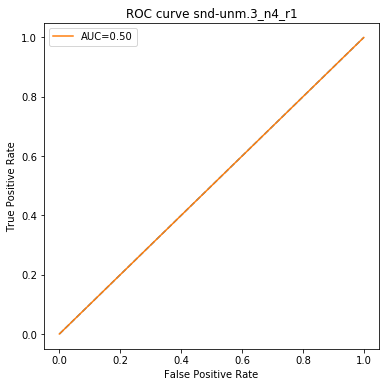

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.4.train -n 4 -r 2 -c -l < syscalls-classification/snd-unm/snd-unm.4.1.test
AUC: 0.559262761203236


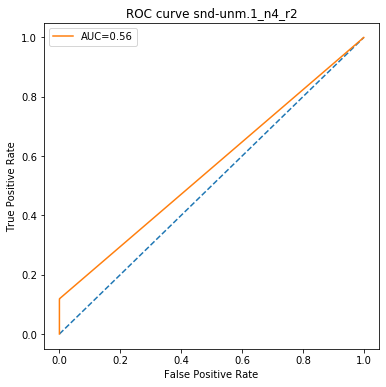

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.4.train -n 4 -r 2 -c -l < syscalls-classification/snd-unm/snd-unm.4.2.test
AUC: 0.5558404590956387


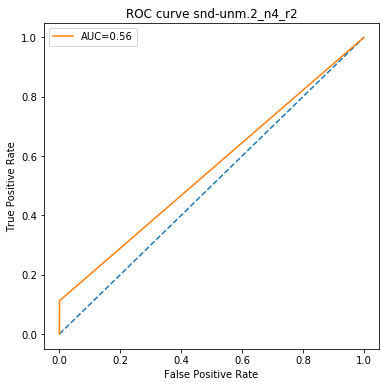

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.4.train -n 4 -r 2 -c -l < syscalls-classification/snd-unm/snd-unm.4.3.test
AUC: 0.5618760566214287


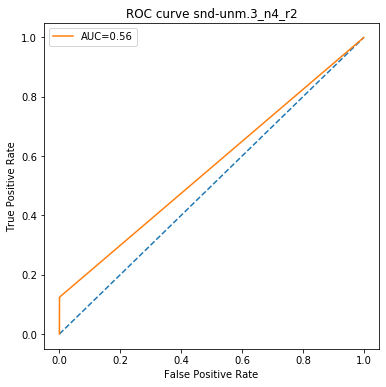

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.4.train -n 4 -r 3 -c -l < syscalls-classification/snd-unm/snd-unm.4.1.test
AUC: 0.5718657402433055


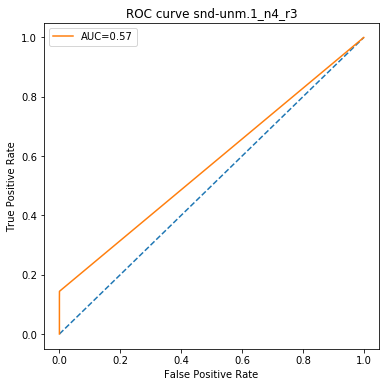

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.4.train -n 4 -r 3 -c -l < syscalls-classification/snd-unm/snd-unm.4.2.test
AUC: 0.567080424470843


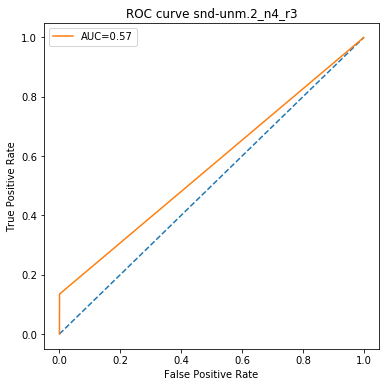

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.4.train -n 4 -r 3 -c -l < syscalls-classification/snd-unm/snd-unm.4.3.test
AUC: 0.5720411028536374


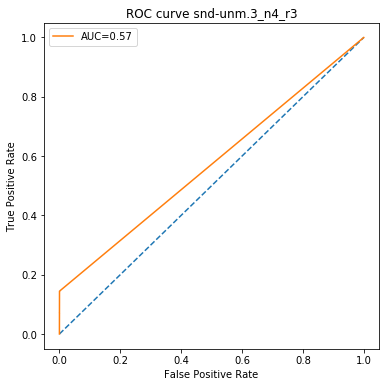

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.4.train -n 4 -r 4 -c -l < syscalls-classification/snd-unm/snd-unm.4.1.test
AUC: 0.5779508852357246


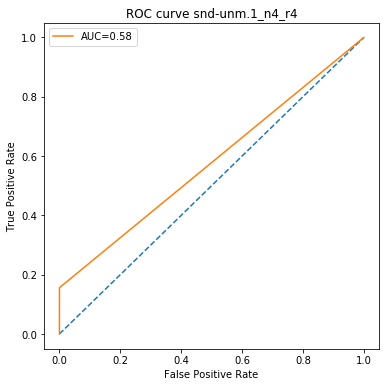

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.4.train -n 4 -r 4 -c -l < syscalls-classification/snd-unm/snd-unm.4.2.test
AUC: 0.5719056348005837


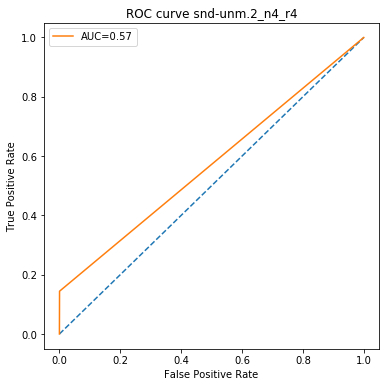

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.4.train -n 4 -r 4 -c -l < syscalls-classification/snd-unm/snd-unm.4.3.test
AUC: 0.5785571435790403


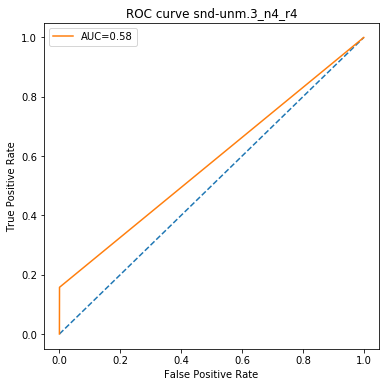

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.5.train -n 5 -r 1 -c -l < syscalls-classification/snd-unm/snd-unm.5.1.test
AUC: 0.5213197969543147


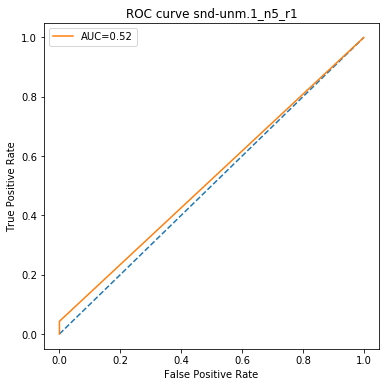

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.5.train -n 5 -r 1 -c -l < syscalls-classification/snd-unm/snd-unm.5.2.test
AUC: 0.5220937539801049


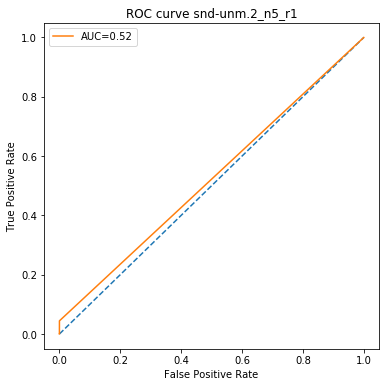

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.5.train -n 5 -r 1 -c -l < syscalls-classification/snd-unm/snd-unm.5.3.test
AUC: 0.5259683131150876


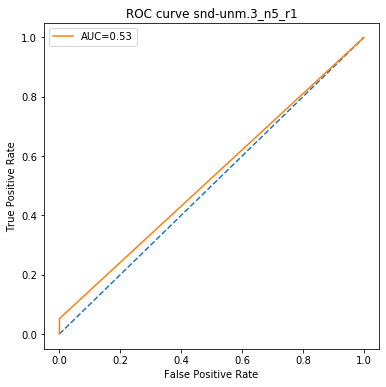

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.5.train -n 5 -r 2 -c -l < syscalls-classification/snd-unm/snd-unm.5.1.test
AUC: 0.5847207749220943


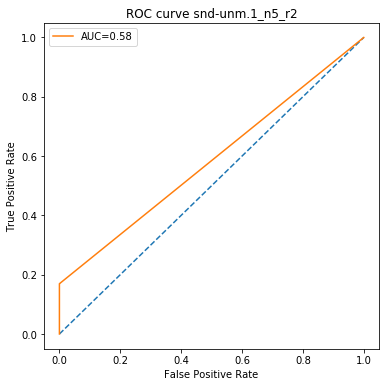

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.5.train -n 5 -r 2 -c -l < syscalls-classification/snd-unm/snd-unm.5.2.test
AUC: 0.5797674969608506


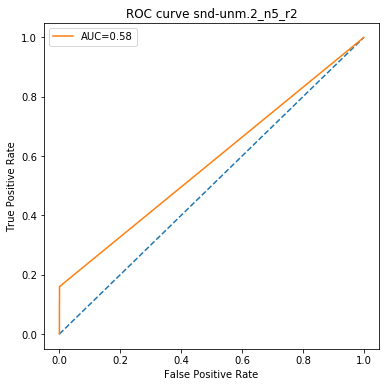

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.5.train -n 5 -r 2 -c -l < syscalls-classification/snd-unm/snd-unm.5.3.test
AUC: 0.5951565996360938


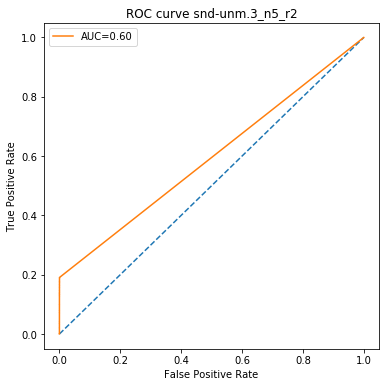

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.5.train -n 5 -r 3 -c -l < syscalls-classification/snd-unm/snd-unm.5.1.test
AUC: 0.6156767961805352


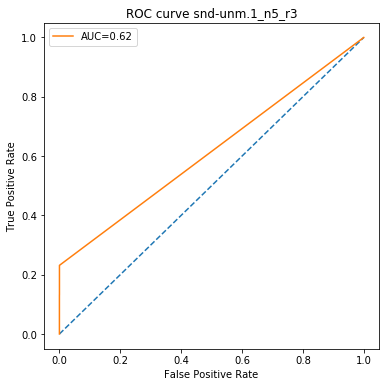

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.5.train -n 5 -r 3 -c -l < syscalls-classification/snd-unm/snd-unm.5.2.test
AUC: 0.6093618670528008


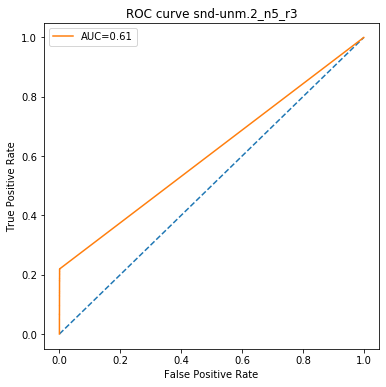

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.5.train -n 5 -r 3 -c -l < syscalls-classification/snd-unm/snd-unm.5.3.test
AUC: 0.6195601957903077


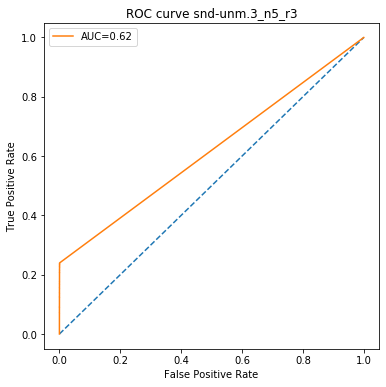

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.5.train -n 5 -r 4 -c -l < syscalls-classification/snd-unm/snd-unm.5.1.test
AUC: 0.624807393505966


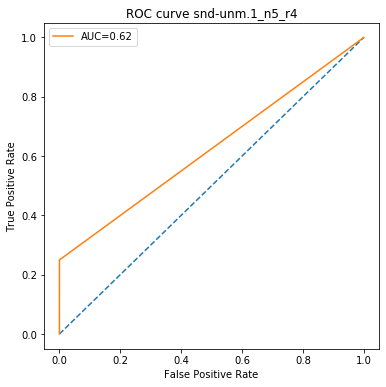

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.5.train -n 5 -r 4 -c -l < syscalls-classification/snd-unm/snd-unm.5.2.test
AUC: 0.6158431734024125


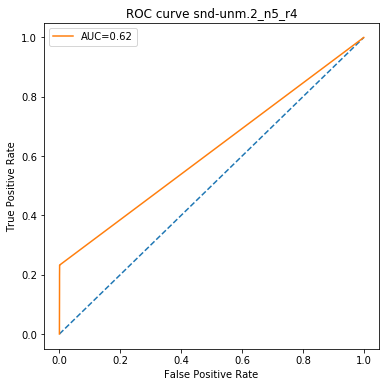

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.5.train -n 5 -r 4 -c -l < syscalls-classification/snd-unm/snd-unm.5.3.test
AUC: 0.6297036178944867


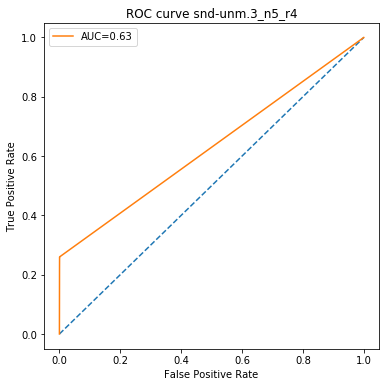

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.5.train -n 5 -r 5 -c -l < syscalls-classification/snd-unm/snd-unm.5.1.test
AUC: 0.6268423837374665


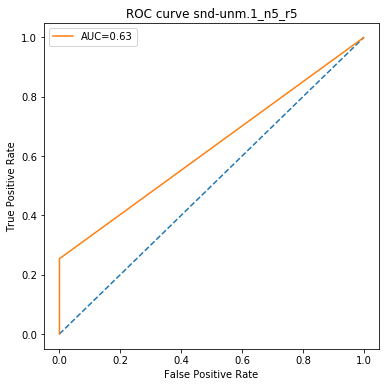

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.5.train -n 5 -r 5 -c -l < syscalls-classification/snd-unm/snd-unm.5.2.test
AUC: 0.6183284712166648


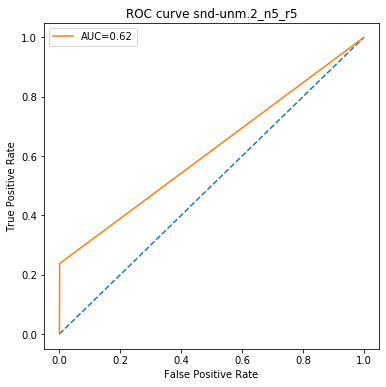

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.5.train -n 5 -r 5 -c -l < syscalls-classification/snd-unm/snd-unm.5.3.test
AUC: 0.6312123860062773


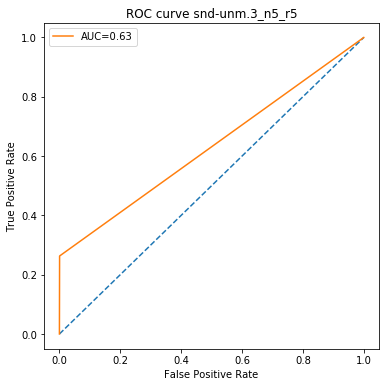

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.6.train -n 6 -r 1 -c -l < syscalls-classification/snd-unm/snd-unm.6.1.test
AUC: 0.5179640718562875


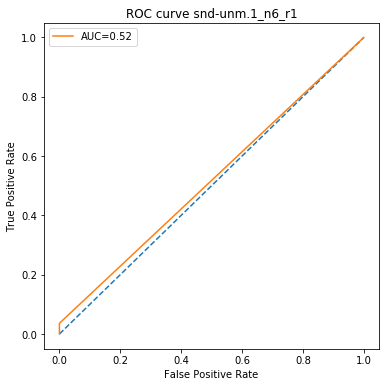

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.6.train -n 6 -r 1 -c -l < syscalls-classification/snd-unm/snd-unm.6.2.test
AUC: 0.5224454927045743


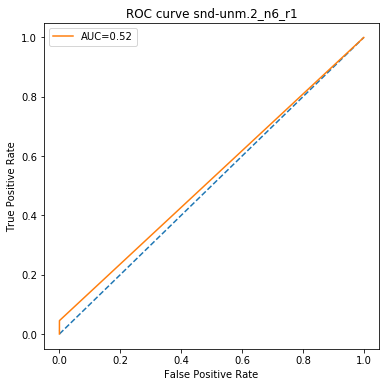

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.6.train -n 6 -r 1 -c -l < syscalls-classification/snd-unm/snd-unm.6.3.test
AUC: 0.5276301609060304


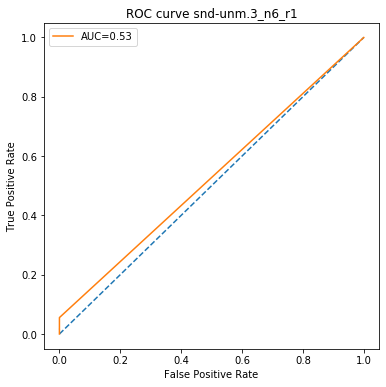

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.6.train -n 6 -r 2 -c -l < syscalls-classification/snd-unm/snd-unm.6.1.test
AUC: 0.6101148033603123


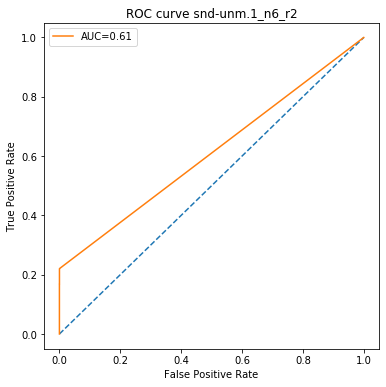

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.6.train -n 6 -r 2 -c -l < syscalls-classification/snd-unm/snd-unm.6.2.test
AUC: 0.6240052417006039


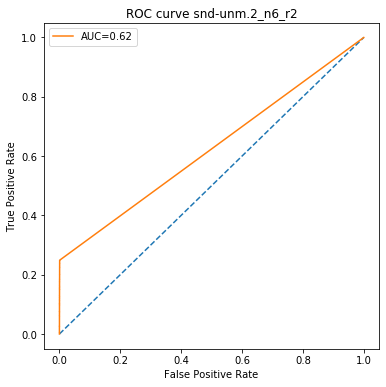

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.6.train -n 6 -r 2 -c -l < syscalls-classification/snd-unm/snd-unm.6.3.test
AUC: 0.6368952735463589


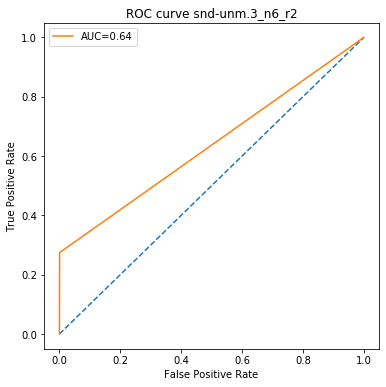

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.6.train -n 6 -r 3 -c -l < syscalls-classification/snd-unm/snd-unm.6.1.test
AUC: 0.6370690706499089


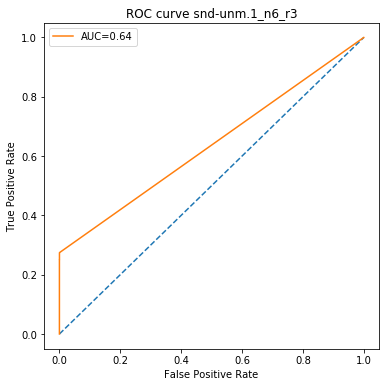

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.6.train -n 6 -r 3 -c -l < syscalls-classification/snd-unm/snd-unm.6.2.test
AUC: 0.6476330424989302


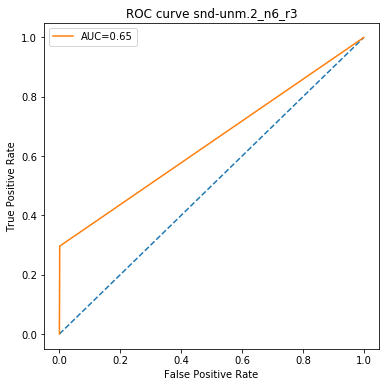

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.6.train -n 6 -r 3 -c -l < syscalls-classification/snd-unm/snd-unm.6.3.test
AUC: 0.6572792166791087


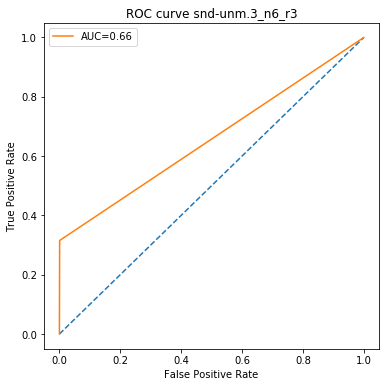

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.6.train -n 6 -r 4 -c -l < syscalls-classification/snd-unm/snd-unm.6.1.test
AUC: 0.6538385207606764


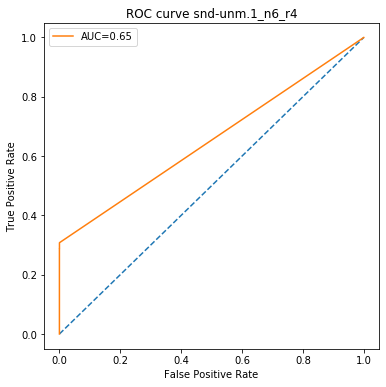

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.6.train -n 6 -r 4 -c -l < syscalls-classification/snd-unm/snd-unm.6.2.test
AUC: 0.6630004585374997


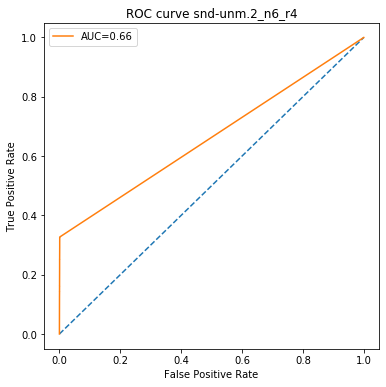

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.6.train -n 6 -r 4 -c -l < syscalls-classification/snd-unm/snd-unm.6.3.test
AUC: 0.6746826438998834


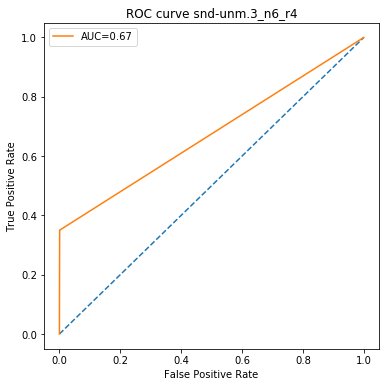

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.6.train -n 6 -r 5 -c -l < syscalls-classification/snd-unm/snd-unm.6.1.test
AUC: 0.65383615187208


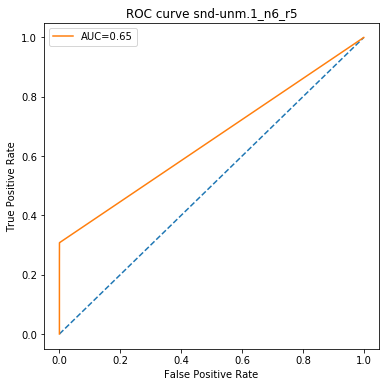

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.6.train -n 6 -r 5 -c -l < syscalls-classification/snd-unm/snd-unm.6.2.test
AUC: 0.664752780968995


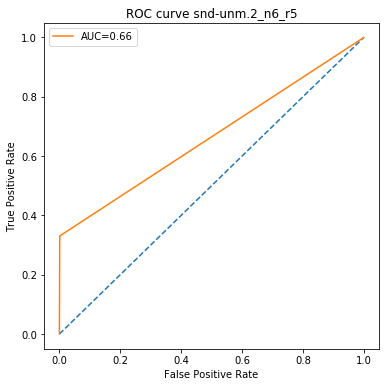

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.6.train -n 6 -r 5 -c -l < syscalls-classification/snd-unm/snd-unm.6.3.test
AUC: 0.674661251826726


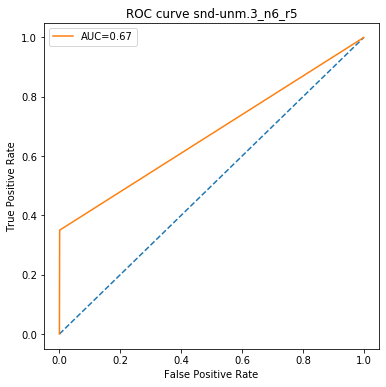

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.6.train -n 6 -r 6 -c -l < syscalls-classification/snd-unm/snd-unm.6.1.test
AUC: 0.6538189554956022


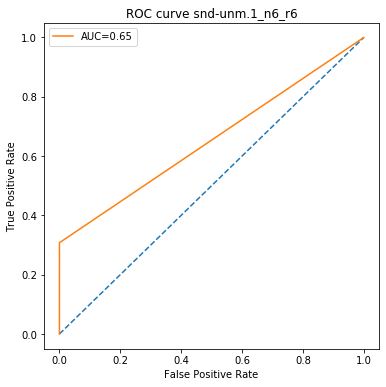

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.6.train -n 6 -r 6 -c -l < syscalls-classification/snd-unm/snd-unm.6.2.test
AUC: 0.6653171354219556


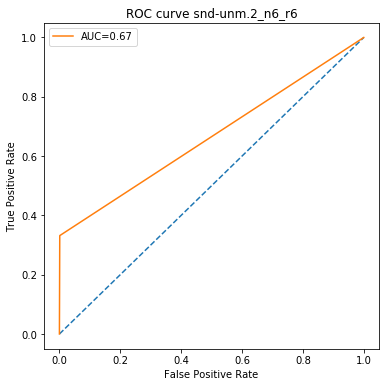

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.6.train -n 6 -r 6 -c -l < syscalls-classification/snd-unm/snd-unm.6.3.test
AUC: 0.6752407320618913


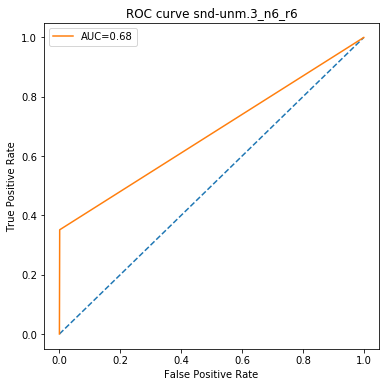

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.7.train -n 7 -r 1 -c -l < syscalls-classification/snd-unm/snd-unm.7.1.test
AUC: 0.5204081632653061


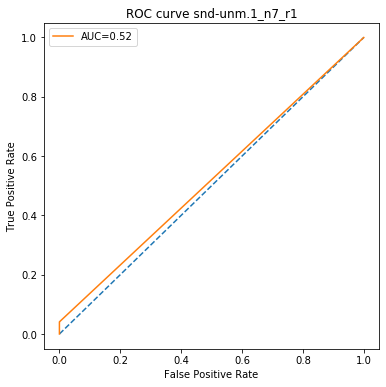

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.7.train -n 7 -r 1 -c -l < syscalls-classification/snd-unm/snd-unm.7.2.test
AUC: 0.5268187350221453


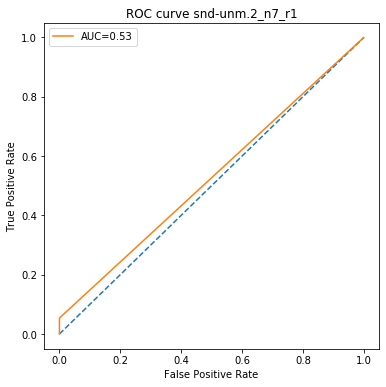

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.7.train -n 7 -r 1 -c -l < syscalls-classification/snd-unm/snd-unm.7.3.test
AUC: 0.5314076202710518


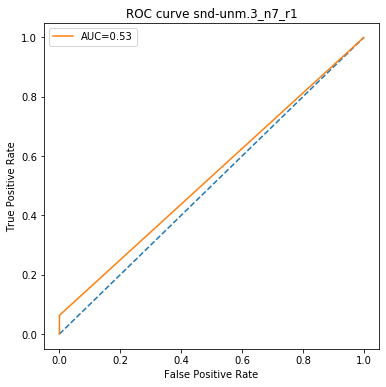

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.7.train -n 7 -r 2 -c -l < syscalls-classification/snd-unm/snd-unm.7.1.test
AUC: 0.6068027210884354


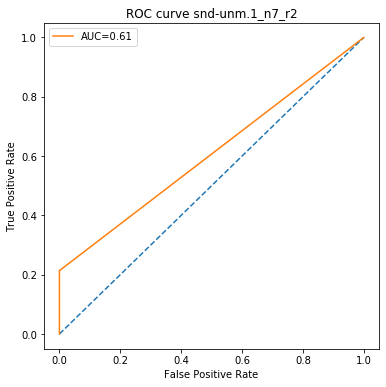

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.7.train -n 7 -r 2 -c -l < syscalls-classification/snd-unm/snd-unm.7.2.test
AUC: 0.6125442382571528


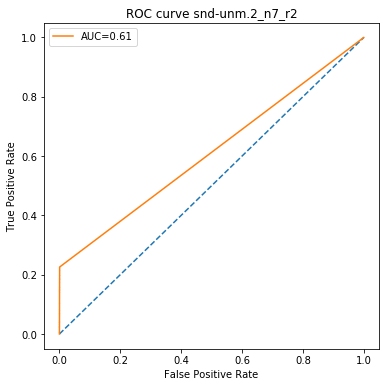

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.7.train -n 7 -r 2 -c -l < syscalls-classification/snd-unm/snd-unm.7.3.test
AUC: 0.6351751596267203


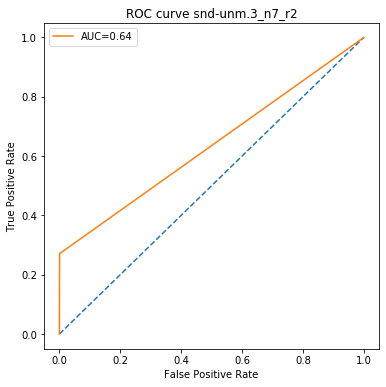

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.7.train -n 7 -r 3 -c -l < syscalls-classification/snd-unm/snd-unm.7.1.test
AUC: 0.64421768707483


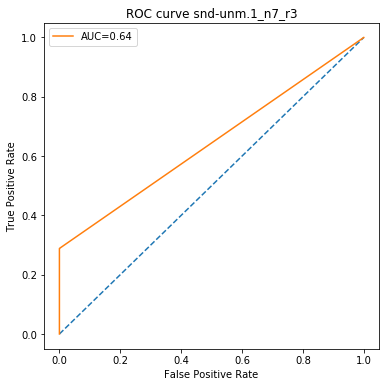

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.7.train -n 7 -r 3 -c -l < syscalls-classification/snd-unm/snd-unm.7.2.test
AUC: 0.6419655545936269


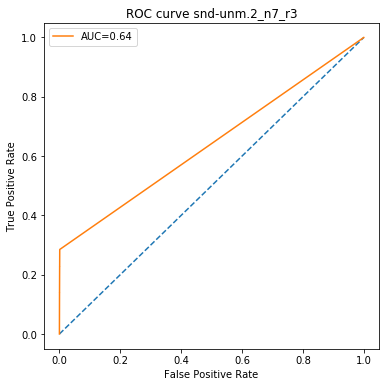

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.7.train -n 7 -r 3 -c -l < syscalls-classification/snd-unm/snd-unm.7.3.test
AUC: 0.6651591776095351


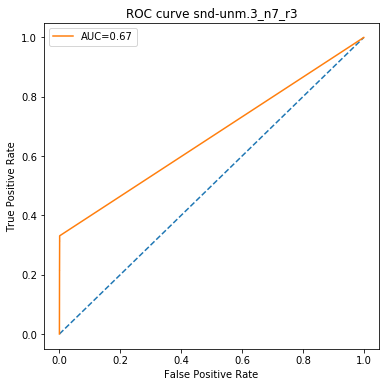

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.7.train -n 7 -r 4 -c -l < syscalls-classification/snd-unm/snd-unm.7.1.test
AUC: 0.654421768707483


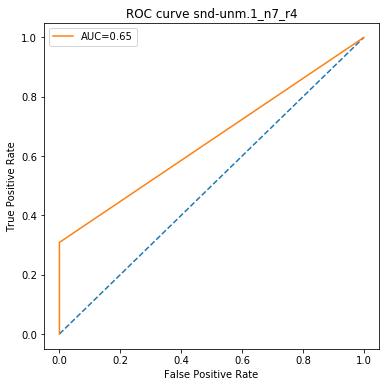

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.7.train -n 7 -r 4 -c -l < syscalls-classification/snd-unm/snd-unm.7.2.test
AUC: 0.6526755519587792


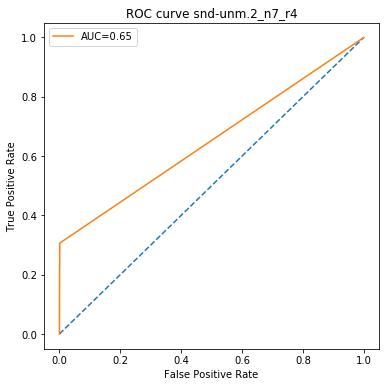

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.7.train -n 7 -r 4 -c -l < syscalls-classification/snd-unm/snd-unm.7.3.test
AUC: 0.6726504582588853


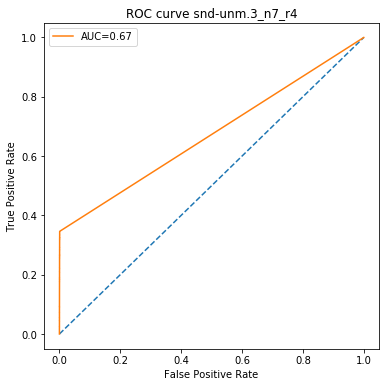

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.7.train -n 7 -r 5 -c -l < syscalls-classification/snd-unm/snd-unm.7.1.test
AUC: 0.6564625850340136


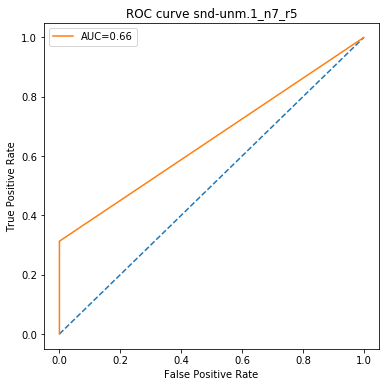

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.7.train -n 7 -r 5 -c -l < syscalls-classification/snd-unm/snd-unm.7.2.test
AUC: 0.6533385089271151


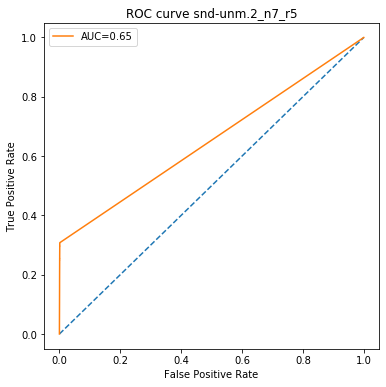

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.7.train -n 7 -r 5 -c -l < syscalls-classification/snd-unm/snd-unm.7.3.test
AUC: 0.6740053934051755


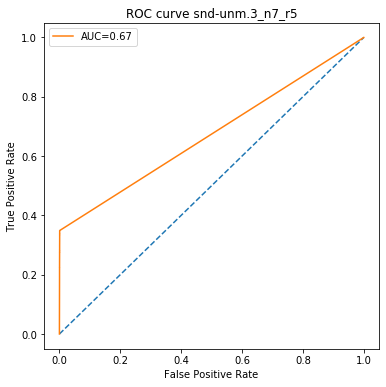

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.7.train -n 7 -r 6 -c -l < syscalls-classification/snd-unm/snd-unm.7.1.test
AUC: 0.6585034013605442


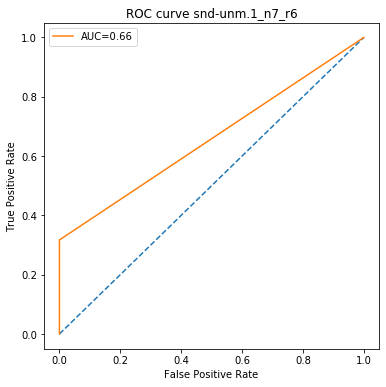

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.7.train -n 7 -r 6 -c -l < syscalls-classification/snd-unm/snd-unm.7.2.test
AUC: 0.6553345211059669


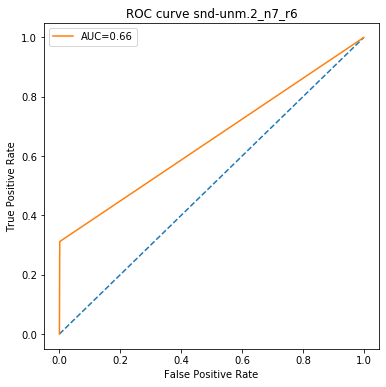

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.7.train -n 7 -r 6 -c -l < syscalls-classification/snd-unm/snd-unm.7.3.test
AUC: 0.6760295839202536


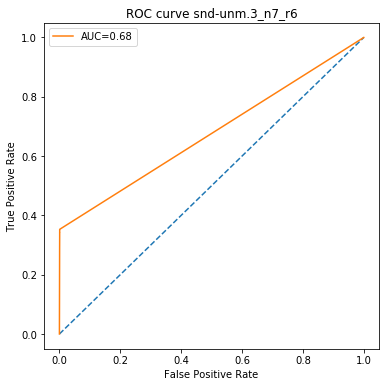

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.7.train -n 7 -r 7 -c -l < syscalls-classification/snd-unm/snd-unm.7.1.test
AUC: 0.6605442176870748


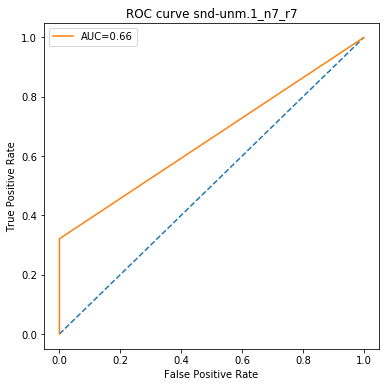

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.7.train -n 7 -r 7 -c -l < syscalls-classification/snd-unm/snd-unm.7.2.test
AUC: 0.6566435176472064


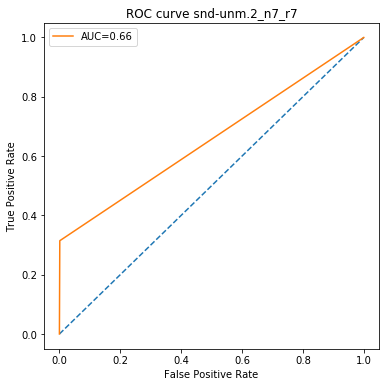

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-unm/snd-unm.alpha -self syscalls-classification/snd-unm/snd-unm.7.train -n 7 -r 7 -c -l < syscalls-classification/snd-unm/snd-unm.7.3.test
AUC: 0.678063078529612


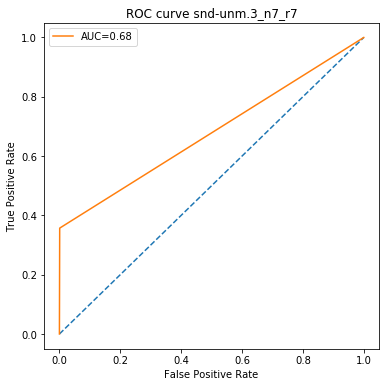

In [15]:
for n, r in chunk_r_tuples:
    self = f"-self {unm_data_path}snd-unm.{n}.train"
    params = f"-n {n} -r {r} -c -l"
    for i in range(1, TEST_N + 1):
        test = f"{unm_data_path}snd-unm.{n}.{i}.test"
        # run negative selection algorithm
        print(f"Execute command: !java {jar} {alpha} {self} {params} < {test}")
        output = !java {jar} {alpha} {self} {params} < {test}
        # string to float
        counts = [float(count) for count in output]
        # read labels and convert to float
        labels = read_data(unm_data_path + "snd-unm.{}.{}.labels".format(n, i))
        labels = [float(label) for label in labels]
        # perform AUC analysis - compute AUC and plot ROC
        fpr, tpr, thresholds = metrics.roc_curve(labels, counts, pos_label=1)
        auc = get_AUC(labels, counts)
        print("AUC:", auc)
        plot_ROC(fpr, tpr, "snd-unm.{}_n{}_r{}".format(i, n, r),
                 "ex2_snd-unm.{}_n{}_r{}".format(i, n, r))
        # store AUC in a dictionary
        auc_dict["snd-unm.{}_n{}_r{}".format(i, n, r)] = auc
    print("=================")

In [16]:
# save auc_dict
with open('auc_dict_unm.pkl', 'wb') as output:
    pickle.dump(auc_dict, output, pickle.HIGHEST_PROTOCOL)

### Step 3: AUC Analysis Task

In [17]:
# load auc_dict
with open('auc_dict_unm.pkl', 'rb') as output:
    auc_dict = pickle.load(output)

In [18]:
avg_auc_dict = dict()
for n,r in chunk_r_tuples:
    auc_vals = [v for k,v in auc_dict.items() if 'n{}_r{}'.format(n,r) in k]
    avg_auc_dict[(n,r)] = np.average(auc_vals)

In [19]:
def plot_auc_over_r(n, auc, filename=None):
    
    plt.figure(figsize=(8, 6))
    for i in range(len(n)):
        r_range = range(1, n[i]+1)
        plt.plot(r_range, auc[i], label="n = {}".format(n[i]))
    plt.xlabel("$r$")
    plt.ylabel("AUC")
    plt.title("AUC for different values of $r$", size=14)
    plt.xticks(r_range)
    plt.ylim(top=1)
    plt.legend()
    plt.grid()
    if filename:
        plt.savefig(f'figures/{filename}.png')
    plt.show()

In [20]:
auc = [[v for k,v in avg_auc_dict.items() if k[0]==i] for i in range(2, CHUNK_LENGTH+1)]
n = [i for i in range(2, CHUNK_LENGTH+1)]

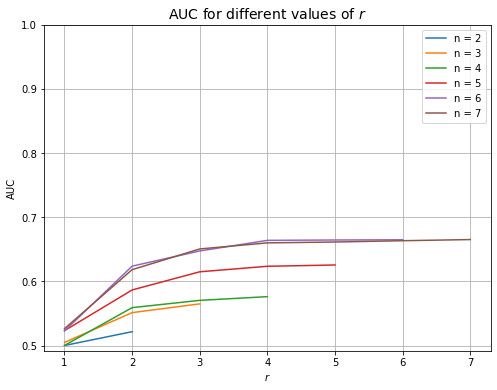

In [21]:
plot_auc_over_r(n, auc, 'ex2_snd-unm.auc')